In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def to_pickle(data,filename):
    with open(filename,'wb') as file:
        pkl.dump(data,file)
        
def load_pickle(filename):
    with open(filename,'rb') as file:
        return pkl.load(file)        

In [2]:
def pred_all(dfs,idx,inds=None):
    if inds == None:
        inds = folds
    lam_pred = []
    w2_pred = []
    wlog_pred = []
    for i,fold in enumerate(folds):
        if i in inds:
            idx=dfs[i].iloc[dfs[i].index.isin(idx)].index
            i_test_good, lambdas_dft, lambdas_pred, w_log_dft, w_log_pred, w_2_dft, w_2_pred = compute_from_a2F(dfs[i],idx,lambda_filter=10.)
            lam_pred.append(lambdas_pred.copy())
            w2_pred.append(w_2_pred.copy())
            wlog_pred.append(w_log_pred.copy())

    lambda_mean, lambda_std = get_mean_std(lam_pred)
    w2_mean, w2_std = get_mean_std(w2_pred)
    wlog_mean, wlog_std = get_mean_std(wlog_pred)
    return lambda_mean, lambdas_dft, w2_mean, w_2_dft,wlog_mean, w_log_dft
    

In [3]:

def compute_from_a2F(df, idx,lambda_filter=10.):
    i_test_good = []
    lambdas_dft = []
    lambdas_pred = []
    w_log_dft = []
    w_log_pred = []
    w_2_dft = []
    w_2_pred = []
    tc_pred = []
    tc_dft = []
    frequency = Freq_final
    for i in idx:
        entry = df.loc[i]
        lambda_tar = cal_lamb(frequency,entry.target)
        i_test_good.append(i)

        w_log_dft.append(cal_w_log(frequency,entry.target,lambda_tar)/0.08617)
        w_2_dft.append(cal_w_sq(frequency,entry.target,lambda_tar)/0.08617)
        lambda_pred = cal_lamb(frequency,entry.pred)
        w_log_pred.append(cal_w_log(frequency,entry.pred,lambda_pred)/0.08617)
        w_2_pred.append(cal_w_sq(frequency,entry.pred,lambda_pred)/0.08617)   
        if lambda_tar > 0.1:
            tc_pred.append(cal_tc(lambda_pred,w_log_pred[-1],.1))
            tc_dft.append(cal_tc(lambda_tar,w_log_dft[-1],.1))
        if lambda_tar < lambda_filter:
            lambdas_dft.append(lambda_tar)
            lambdas_pred.append(lambda_pred)
    return i_test_good, lambdas_dft, lambdas_pred, w_log_dft, w_log_pred, w_2_dft, w_2_pred#,tc_pred,tc_dft

In [4]:
def cal_lamb(freq_w,alpha_F):
    lambdaF = 0
    try:
        for i in range(1,len(freq_w)):
            dw = freq_w[i] - freq_w[i-1]
            w = freq_w[i]
            alpha_F_w = alpha_F[i]
            lambdaF = lambdaF + ((alpha_F_w/w)*dw)
        return 2*lambdaF
    except:
        return np.nan

def cal_w_log(freq_w,alpha_F,lamb):
    w_logF = 0
    try:
        for i in range(1,len(freq_w)):
            dw = freq_w[i] - freq_w[i-1]
            w_logF = w_logF + (alpha_F[i]*np.log(freq_w[i])*dw/freq_w[i])
        return np.exp(2*w_logF/lamb)
    except: 
        return np.nan

def cal_w_sq(freq_w,alpha_F,lamb):
    w_sqF = 0
    try:
        for i in range(1,len(freq_w)):
            dw = freq_w[i] - freq_w[i-1]
            w_sqF = w_sqF + (alpha_F[i]*freq_w[i]*dw)
        return (2*w_sqF/lamb)**.5
    except:
        return np.nan

def cal_tc(lamb, omega_log,mu=0.09):
    frac = -1.04*(1+lamb)/(lamb-mu*(1+0.62*lamb))
    return (omega_log/1.2)*np.exp(frac)    

def cal_tc_ad(lamb,wlog,w2,tc,mu=0.1):
    f1 = (1+(lamb/(2.46*(1+3.8*mu)))**1.5)**(1/3)
    f2 = 1+((lamb**2)*((w2/wlog)-1))/(lamb**2+(1.82*(1+6.3*mu)*(w2/wlog))**2)
    return f1*f2*tc


def compute_from_a2F(df, idx,lambda_filter=10.):
    i_test_good = []
    lambdas_dft = []
    lambdas_pred = []
    w_log_dft = []
    w_log_pred = []
    w_2_dft = []
    w_2_pred = []
    tc_pred = []
    tc_dft = []
    tcad_pred = []
    tcad_dft = []
    frequency = Freq_final
    for i in idx:
        entry = df.loc[i]
        lambda_tar = cal_lamb(frequency,entry.target)
        i_test_good.append(i)

        w_log_dft.append(cal_w_log(frequency,entry.target,lambda_tar)/0.08617)
        w_2_dft.append(cal_w_sq(frequency,entry.target,lambda_tar)/0.08617)
        lambda_pred = cal_lamb(frequency,entry.pred)
        w_log_pred.append(cal_w_log(frequency,entry.pred,lambda_pred)/0.08617)
        w_2_pred.append(cal_w_sq(frequency,entry.pred,lambda_pred)/0.08617)   
        if lambda_tar > 0.1:
            tc_pred.append(cal_tc(lambda_pred,w_log_pred[-1],.1))
            tc_dft.append(cal_tc(lambda_tar,w_log_dft[-1],.1))
            tcad_pred.append(cal_tc_ad(lambda_pred,w_log_pred[-1],w_2_pred[-1],tc_pred[-1],.1))
            tcad_dft.append(cal_tc_ad(lambda_tar,w_log_dft[-1],w_2_dft[-1],tc_dft[-1],.1))
        if lambda_tar < lambda_filter:
            lambdas_dft.append(lambda_tar)
            lambdas_pred.append(lambda_pred)
    return i_test_good, lambdas_dft, lambdas_pred, w_log_dft, w_log_pred, w_2_dft, w_2_pred,tc_pred,tc_dft,tcad_pred,tcad_dft

In [5]:
ang = r'$\mathring{A}$'
lamb = r'$\lambda$'
om_s = r'$\sqrt{\left \langle \omega^{2} \right \rangle}$'
om_l = r'$\omega_{log}$'

In [6]:
i=90
idx_valid = pd.Index(np.loadtxt(f'indices/idx_valid_V1_{i}.txt'))
idx_test = np.loadtxt('indices/idx_valid_final.txt')
idx_train = np.loadtxt('indices/idx_train_final.txt')

In [7]:
Freq_final =np.arange(0.25,101,2)
Freq_final_E =np.arange(-50,50,1)

In [50]:
df_3 = pd.read_json('test_preds/CSO_conf.json')
df_2 = pd.read_json('test_preds/CPD_conf.json')
df_1 = pd.read_json('test_preds/FPD_conf.json')
df_base = pd.read_json('test_preds/base_conf.json')

In [51]:
iv2, lambdas_dft, lambdas_pred, w_log_dft, w_log_pred, w_2_dft, w_2_pred,tc_pred,tc_tar,tc_pred,\
tc_tar3 = compute_from_a2F(df_3,sorted(idx_test)[1:],lambda_filter=10.)
# _, lambdas_dft, lambdas_pred, w_log_dft, w_log_pred, w_2_dft, w_2_pred,tc_pred,tc_tar,tc_pred,tc_tar = compute_from_a2F(df_2,df_2.loc[df_2.index.isin(idx_test)].index,lambda_filter=10.)
tar3 = []
pred3 = []
for p,t in zip(tc_pred,tc_tar3):
#     tar.append(t)
#     pred.append(p)    
    if (t<100) and (p>0.0):
        tar3.append(t)
        pred3.append(p)

In [52]:
_, lambdas_dft, lambdas_pred, w_log_dft, w_log_pred, w_2_dft, w_2_pred,tc_pred,tc_tar,tc_pred\
,tc_tar2= compute_from_a2F(df_2,df_2.loc[df_2.index.isin(idx_test)].index,lambda_filter=10.)
tar2 = []
pred2 = []
for p,t in zip(tc_pred,tc_tar2):
#     tar.append(t)
#     pred.append(p)    
    if (t<100) and (p>0.):
        tar2.append(t)
        pred2.append(p)

In [53]:
iv2, lambdas_dft, lambdas_pred, w_log_dft, w_log_pred, w_2_dft, w_2_pred,tc_pred,tc_tar,tc_pred,\
tc_tar1 = compute_from_a2F(df_1,sorted(idx_test)[1:],lambda_filter=10.)
tar1 = []
pred1 = []
for p,t in zip(tc_pred,tc_tar1):
#     tar.append(t)
#     pred.append(p)    
    if (t<100) and (p>0):
        tar1.append(t)
        pred1.append(p)

In [55]:
scores_base = list(np.asarray(df_base.Base_model_Pred_Tc)/max(df_base.Base_model_Pred_Tc))
y_true_base = []
for p,t in zip(df_base.Base_model_Pred_Tc,df_base.DFT_Tc):
    if t > 5:
        y_true_base.append(1)
    else:
        y_true_base.append(0)

In [56]:
scores_3 = list(np.asarray(pred3)/max(pred3))
y_true_3 = []
for p,t in zip(pred3,tar3):
    if t > 5:
        y_true_3.append(1)
    else:
        y_true_3.append(0)
    

In [57]:
scores_2 = list(np.asarray(pred2)/max(pred2))
y_true_2 = []
for p,t in zip(pred2,tar2):
    if t > 5:
        y_true_2.append(1)
    else:
        y_true_2.append(0)
    

In [58]:
scores_1 = list(np.asarray(pred1)/max(pred1))
y_true_1 = []
for p,t in zip(pred1,tar1):
    if t > 5:
        y_true_1.append(1)
    else:
        y_true_1.append(0)

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [60]:
mae = mean_absolute_error(tar3,pred3)

In [61]:
mae

2.517810651804502

In [62]:
mae = mean_absolute_error(tar1,pred1)

In [63]:
mae

2.1445803327135833

In [64]:
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score, average_precision_score
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D

In [65]:
prec = 33/173
tp = 1
fp = 0
tpr_random =[]
fpr_random =[]
precision_random = []
for total in range(174):
    fn = 33 - tp
    tn = 140 -fp
    tpr_random.append(tp/33)
    fpr_random.append(fp/140)    
    precision_random.append(tp/(fp+tp))    
    if int((fp+tp)*prec) == (tp+1):
        tp +=1
    else:
        fp +=1



In [66]:
import numpy as np
from sklearn import metrics
def set_plt_params(fs=18):
    plt.rcParams['font.size'] = fs
    plt.rcParams['axes.titlesize'] = fs
    plt.rcParams['axes.labelsize'] = fs
    plt.rcParams['legend.fontsize'] = fs
    plt.rcParams['xtick.labelsize'] = fs
    plt.rcParams['ytick.labelsize'] = fs
set_plt_params(12)
lw_pe=2


In [67]:

sns.set_style('white')
sns.set_context("paper")

In [68]:
p = 33/161

In [69]:
df_base.head()

,comp,ase_atom_obj,a2F_Freq_meV,a2F,PhFreq_meV,Tot_PhDOS,Site_Proj_PhDOS,lambda,w_log,w_sq,...,AW,unitcell_vol,phlam,phwlog,phw2,lambda_pred,wlog_pred,wsq_pred,DFT_Tc,Base_model_Pred_Tc
34,MoN,"{'arrays': {'numbers': [42, 7], 'positions': [...","[0.2500007289, 0.3500026531, 0.450003216700000...","[1.022e-07, 2.806e-07, 5.963e-07, 1.0887e-06, ...","[-1.157e-06, 0.0999997096, 0.2000005762, 0.300...","[0.0, 7.771e-07, 3.1084e-06, 6.994e-06, 1.2433...","[[0.0, 6.783e-07, 2.7137e-06, 6.1071e-06, 1.08...",1.079585,32.183310,1517.118250,...,"[95.95, 14.007]",19.826413,0.399659,25.067496,34.536008,0.452770,26.583284,35.120268,31.282592,2.499978
4,CTa,"{'arrays': {'numbers': [73, 6], 'positions': [...","[0.2500007289, 0.3500026531, 0.450003216700000...","[1.0665e-06, 2.9266e-06, 6.22e-06, 1.13564e-05...","[-8.931000000000001e-07, 0.0999999735, 0.20000...","[0.0, 3.7002e-06, 1.4800900000000001e-05, 3.33...","[[0.0, 3.4710000000000003e-06, 1.38881e-05, 3....",1.685703,17.721746,975.894906,...,"[180.94788, 12.011]",22.575664,0.506571,17.764356,30.724316,0.494023,19.029998,31.276581,30.800096,2.621879
46,N2Zr2,"{'arrays': {'numbers': [40, 40, 7, 7], 'positi...","[0.2500020894, 0.3500026531, 0.450003216700000...","[1.6580000000000002e-07, 4.5500000000000004e-0...","[-2.86e-07, 0.1000005806, 0.20000144720000002,...","[0.0, 4.0803000000000006e-06, 1.63212000000000...","[[0.0, 1.7684e-06, 7.0725000000000005e-06, 1.5...",0.972456,32.635221,1814.224598,...,"[91.224, 91.224, 14.007, 14.007]",55.479176,0.814570,24.175692,34.184825,0.397018,25.660934,34.766137,26.956034,1.217661
8,Nb2S4,"{'arrays': {'numbers': [41, 41, 16, 16, 16, 16...","[0.2500020894, 0.3500026531, 0.450003216700000...","[2.02715e-05, 3.97322e-05, 6.56797e-05, 9.8114...","[-5.447000000000001e-07, 0.10000032190000001, ...","[0.0, 0.001231033, 0.0024620719, 0.0036931108,...","[[0.0, 0.0003643446, 0.00072902, 0.0010940099,...",1.517852,13.673403,379.882454,...,"[92.90637, 92.90637, 32.06, 32.06, 32.06, 32.06]",111.084383,1.673730,15.283076,23.782526,0.443577,16.463729,24.276523,20.926555,1.405778
56,B2Ta,"{'arrays': {'numbers': [73, 5, 5], 'positions'...","[0.2500020894, 0.3500026531, 0.450004577300000...","[1.59e-07, 4.364e-07, 9.275e-07, 1.6934e-06, 2...","[0.0, 0.1000008666, 0.2000017331, 0.3000025997...","[0.0, 1.5357e-06, 6.1428e-06, 1.38213000000000...","[[0.0, 1.3725e-06, 5.4933e-06, 1.23669e-05, 2....",0.920773,25.040382,1942.812582,...,"[180.94788, 10.81, 10.81]",27.035828,0.601339,21.176903,41.040031,0.411930,22.559431,41.678886,18.926586,1.318541


In [70]:
predbase = df_base.Base_model_Pred_Tc
tarbase = df_base.DFT_Tc

In [71]:
precision_base, recall_base, thresholds_base = precision_recall_curve(y_true_base, scores_base)
thresholds_base = thresholds_base*max(df_base.Base_model_Pred_Tc)

precision_1, recall_1, thresholds_1 = precision_recall_curve(y_true_1, scores_1)
thresholds_1 = thresholds_1*max(pred1)

precision_2, recall_2, thresholds_2 = precision_recall_curve(y_true_2, scores_2)
thresholds_2 = thresholds_2*max(pred2)

precision_3, recall_3, thresholds_3 = precision_recall_curve(y_true_3, scores_3)
thresholds_3 = thresholds_3*max(pred3)

auc_3 = average_precision_score(y_true_3,scores_3)
auc_2 = average_precision_score(y_true_2,scores_2)
auc_1 = average_precision_score(y_true_1,scores_1)
auc_base = average_precision_score(y_true_base,scores_base)


In [72]:
thresholds = np.array(list(thresholds_1)+list(thresholds_2)
                      +list(thresholds_3)+list(thresholds_base))

In [73]:
norm = plt.Normalize(min(thresholds), max(thresholds))
colors_1 = plt.cm.rainbow(norm(thresholds_1))
colors_2 = plt.cm.rainbow(norm(thresholds_2))
colors_3 = plt.cm.rainbow(norm(thresholds_3))
colors_base = plt.cm.rainbow(norm(thresholds_base))


In [74]:
lw_pe=5

In [75]:
sns.set_context('talk')
set_plt_params(9.5)
sns.set_context({'axes.linewidth': 1.875/2,
 'grid.linewidth': 1.5/2,
 'lines.linewidth': 2.25/2,
 'lines.markersize': 4.5,
 'patch.linewidth': 1.5/2,
 'xtick.major.width': 1.875/2,
 'ytick.major.width': 1.875/2,
 'xtick.minor.width': .75,
 'ytick.minor.width': .75,
 'xtick.major.size': 4.5,
 'ytick.major.size': 4.5,
 'xtick.minor.size': 3.0,
 'ytick.minor.size': 3.0})
import matplotlib as mpl

# Set the global font to be Times New Roman
mpl.rcParams['font.family'] = 'sans-serif'

In [88]:
def get_confusion(thres,pred,tar):
    y_true = []
    y_pred = []
    for p,t in zip(pred,tar):
        if t > 5:
            y_true.append(1)
        else:
            y_true.append(0)
        if p >thres:
            y_pred.append(1)
        else:
            y_pred.append(0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    t=tp+fp+tn+fn
    cm2 = np.asarray([[0,0],[0,0]])
    tpb = round((tp+fp)*(tp+fn)/t)
    fnb = (tp+fn)-tpb
    fpb = round((tp+fp)*(tn+fp)/t) 
    tnb = (tn+fp)-fpb
    return tp, fp, tn, fn, t, tpb, fnb, fpb, tnb

In [89]:
tp, fp, tn, fn, t, tpb, fnb, fpb, tnb = get_confusion(1.6,pred1,tar1)

cm2f = [[tp,fn],[fp,tn]]
anf =  [[f'{tp}\n({tpb})',f'{fn}\n({fnb})'],[f'{fp}\n({fpb})',f'{tn}\n({tnb})']]
rf = tp/(tp+fn)
pf= tp/(tp+fp)


In [90]:
tp, fp, tn, fn, t, tpb, fnb, fpb, tnb = get_confusion(5.8,pred3,tar3)

cm21 = [[tp,fn],[fp,tn]]
an1 =  [[f'{tp}\n({tpb})',f'{fn}\n({fnb})'],[f'{fp}\n({fpb})',f'{tn}\n({tnb})']]
r1 = tp/(tp+fn)
p1= tp/(tp+fp)

In [91]:
tp, fp, tn, fn, t, tpb, fnb, fpb, tnb = get_confusion(2.85,pred2,tar2)

cm22 = [[tp,fn],[fp,tn]]
an22 =  [[f'{tp}\n({tpb})',f'{fn}\n({fnb})'],[f'{fp}\n({fpb})',f'{tn}\n({tnb})']]

r2 = tp/(tp+fn)
p2= tp/(tp+fp)

In [92]:
tp, fp, tn, fn, t, tpb, fnb, fpb, tnb = get_confusion(2.32,predbase,tarbase)

cm2base = [[tp,fn],[fp,tn]]
anbase =  [[f'{tp}\n({tpb})',f'{fn}\n({fnb})'],[f'{fp}\n({fpb})',f'{tn}\n({tnb})']]

rbase = tp/(tp+fn)
pbase= tp/(tp+fp)


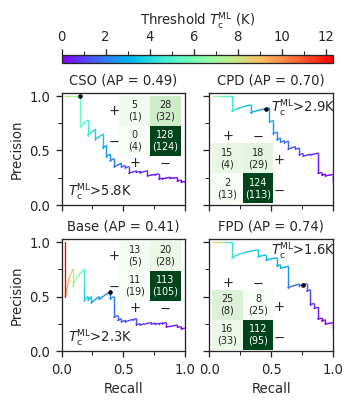

In [94]:
fig,axes = plt.subplots(2,2,sharex=True, sharey = True,figsize=(3.5, 3.75))
plt.subplots_adjust(hspace=0.3)
axes = axes.flatten()
# Creating a color map based on the thresholds
lw = 1

for i in range(len(thresholds_base)-1):
    axes[2].plot(recall_base[i:i+2], precision_base[i:i+2], '-', color=colors_base[i],lw=lw) 
 
for i in range(len(thresholds_3)-1):
    axes[0].plot(recall_3[i:i+2], precision_3[i:i+2], '-', color=colors_3[i],lw=lw)
    
for i in range(len(thresholds_2)-1):
    axes[1].plot(recall_2[i:i+2], precision_2[i:i+2], '-', color=colors_2[i],lw=lw)
    
for i in range(len(thresholds_1)-1):
    axes[3].plot(recall_1[i:i+2], precision_1[i:i+2], color=colors_1[i],lw=lw)
y=1

axes[2].set_title(f'Base (AP = {auc_base:.2f})',y=y)
axes[0].set_title(f'CSO (AP = {auc_3:.2f})',y=y)
axes[1].set_title(f'CPD (AP = {auc_2:.2f})',y=y)
axes[3].set_title(f'FPD (AP = {auc_1:.2f})',y=y)    

axes[2].set_xlabel('Recall')
axes[3].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[2].set_ylabel('Precision')

cbar_coords = [.125,.88,.775,.02]
cb_ax = fig.add_axes(cbar_coords)

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='rainbow'),location='top', label=r'Threshold '+r'$T\mathrm{_c^{ ML}}$' + ' (K)',cax=cb_ax)
cbar.set_ticks([0,2,4,6,8,10,12])
cbar.set_ticks([1,3,5,7,9,11],minor=True)

fig.subplots_adjust(top=0.8)
cm_ax = fig.add_axes([0.555, 0.5052, 0.175, 0.16])  # for example, a box at the middle right of the figure
heatmap = sns.heatmap(cm22,ax=cm_ax, annot=an22, fmt='s', xticklabels=[r'$+$',r'$-$'], yticklabels=[r'$+$',r'$-$'],cmap='Greens',cbar=None,annot_kws={"fontsize":7})
cm_ax.tick_params(axis='x', which='major', pad=0,length=0)  # Adjust x-axis label padding
cm_ax.xaxis.set_ticks_position('top')
cm_ax.tick_params(axis='y', which='major', pad=0,length=0,rotation=0)  # Adjust x-axis label padding
cm_ax.yaxis.set_ticks_position('right')
axes[1].text(.50,.85,r'$T\mathrm{_c^{ ML}}$>'+f'2.9K',fontsize=9.5)
axes[1].scatter(r2,p2,marker='.',c='k',zorder=10,s=25)

cm_ax1 = fig.add_axes([0.29, 0.632, 0.175, 0.16])  # for example, a box at the middle right of the figure
heatmap = sns.heatmap(cm21,ax=cm_ax1, annot=an1, fmt='s', xticklabels=[r'$+$',r'$-$'], yticklabels=[r'$+$',r'$-$'],cmap='Greens',cbar=None,annot_kws={"fontsize":7})
cm_ax1.tick_params(axis='x', which='major', pad=0,length=0)  # Adjust x-axis label padding
cm_ax1.xaxis.set_ticks_position('bottom')
cm_ax1.tick_params(axis='y', which='major', pad=0,length=0,rotation=0)  # Adjust x-axis label padding
cm_ax1.yaxis.set_ticks_position('left')
axes[0].text(.050,.085,r'$T\mathrm{_c^{ ML}}$>'+f'5.8K',fontsize=9.5)
axes[0].scatter(r1,p1,marker='.',c='k',zorder=10,s=25)

### BASE
cm_axbase = fig.add_axes([0.29, 0.245, 0.175, 0.16])  # for example, a box at the middle right of the figure
heatmap = sns.heatmap(cm2base,ax=cm_axbase, annot=anbase, fmt='s', xticklabels=[r'$+$',r'$-$'], yticklabels=[r'$+$',r'$-$'],cmap='Greens',cbar=None,annot_kws={"fontsize":7})
cm_axbase.tick_params(axis='x', which='major', pad=0,length=0)  # Adjust x-axis label padding
cm_axbase.xaxis.set_ticks_position('bottom')
cm_axbase.tick_params(axis='y', which='major', pad=0,length=0,rotation=0)  # Adjust x-axis label padding
cm_axbase.yaxis.set_ticks_position('left')
axes[2].text(.050,.085,r'$T\mathrm{_c^{ ML}}$>'+f'2.3K',fontsize=9.5)
axes[2].scatter(rbase,pbase,marker='.',c='k',zorder=10,s=25)

### FPD
cm_axf = fig.add_axes([0.555, 0.114, 0.175, 0.16])  # for example, a box at the middle right of the figure
heatmap = sns.heatmap(cm2f,ax=cm_axf, annot=anf, fmt='s', xticklabels=[r'$+$',r'$-$'], yticklabels=[r'$+$',r'$-$'],cmap='Greens',cbar=None,annot_kws={"fontsize":7})
cm_axf.tick_params(axis='x', which='major', pad=0,length=0)  # Adjust x-axis label padding
cm_axf.xaxis.set_ticks_position('top')
cm_axf.tick_params(axis='y', which='major', pad=0,length=0,rotation=0)  # Adjust x-axis label padding
cm_axf.yaxis.set_ticks_position('right')
axes[3].text(.50,.88,r'$T\mathrm{_c^{ ML}}$>'+f'1.6K',fontsize=9.5)
axes[3].scatter(rf,pf,marker='.',c='k',zorder=10,s=25)


for ax in axes:
    ax.set_xticks([0,.5,1.])
    ax.set_yticks([0,.5,1.])
    ax.set_xticks([0.25,0.75],minor=True)
    ax.set_yticks([0.25,0.75],minor=True)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)    
    ax.tick_params(axis='y', which='both', left=True, top=False, labelbottom=False)
    ax.set_xlim([0,1.0])
    ax.set_ylim([0,1.03])
    
axes[2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)    
axes[3].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)    